In [243]:
import pandas as pd
import numpy as np

In [244]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline

In [246]:
all_series = {
    "international-airline-passengers": airlines_passengers["Count"],
    "daily-total-female-births-in-cal": female_births["Count"]
}

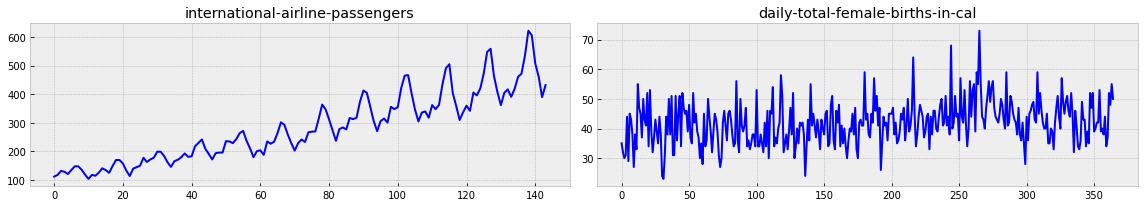

In [247]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

MA

In [248]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

WMA

In [249]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

EMA

In [250]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
# визуализируем

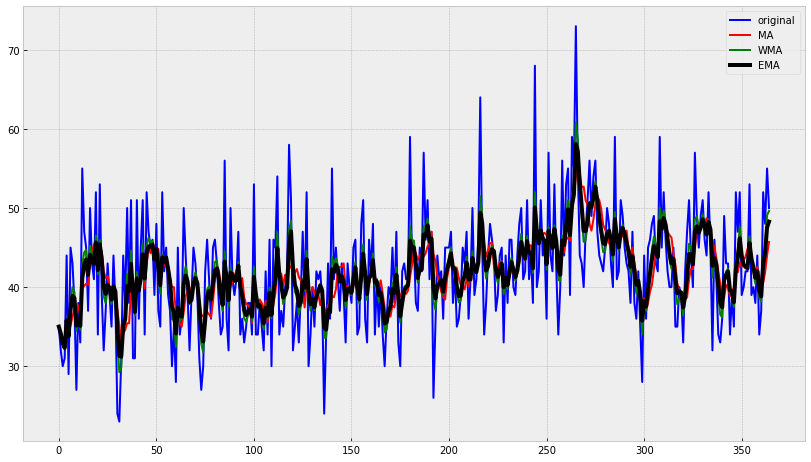

In [258]:
ema = exponential_moving_average(female_births["Count"], 0.3)
wma = weighted_moving_average(female_births["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

DEMA

In [259]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [260]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

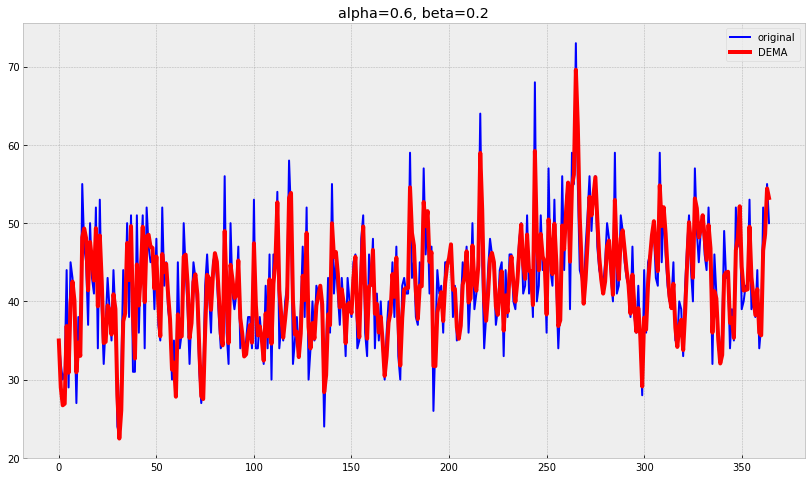

In [261]:
plot_dema(0.6, 0.2)

TEMA

In [262]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [264]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
   
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [265]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [266]:
def plot_tema(alpha, beta, gamma, ser=female_births["Count"], ser_to_plot=female_births["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

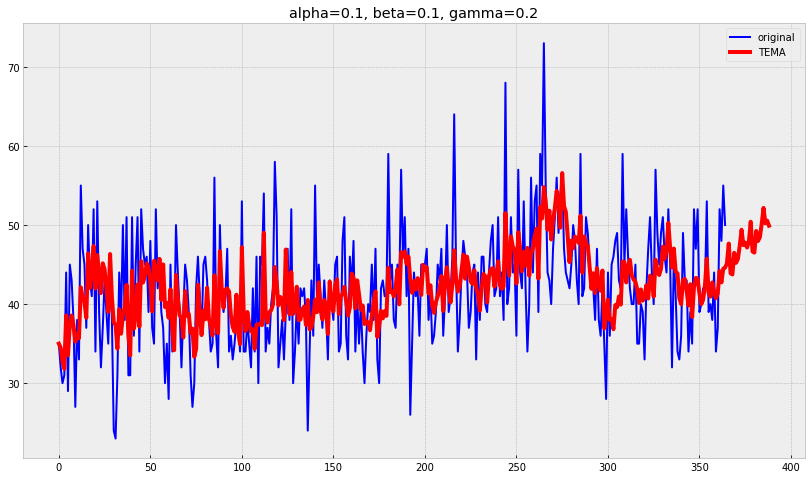

In [267]:
plot_tema(0.1, 0.1, 0.2)

# Подбор параметров

In [268]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [269]:
series = female_births["Count"]

In [270]:
len(series)

365

In [315]:
train, test, val = series[:290], series[290:330], series[330:]

In [316]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [317]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [318]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 89.93201063468473
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-53.777367,   0.      ,  -0.      ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([1.        , 0.00903971, 1.        ])


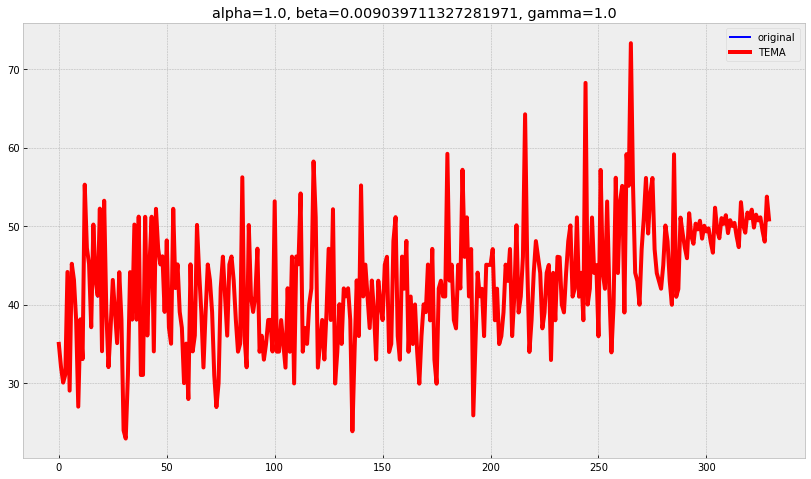

In [319]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

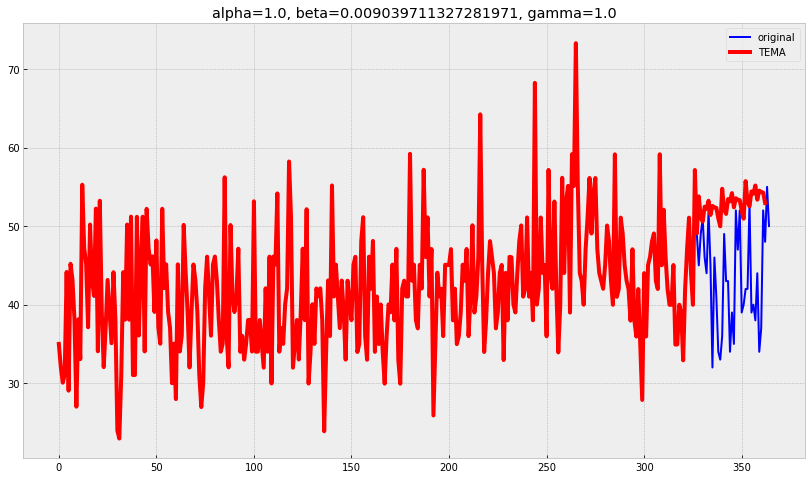

In [320]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:328], ser_to_plot=series, n_preds=len(val))

# Кросс-валидация

In [321]:
train, val = series[:290], series[290:]

In [322]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [323]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

194.93925486538896------------
190.8388724819847------------
194.93925486538896------------
194.59079617622012------------
191.96114960887576------------
190.02220791925342------------
187.6495235482229------------
185.86418713394698------------
181.77487637560375------------
181.67261344286388------------
176.91878490872787------------
173.94415715686057------------
166.5665848968885------------
163.69684460607598------------
153.95749089636493------------
151.5973545830482------------
140.28169556054596------------
134.95417496439836------------
121.6914837470196------------
117.88092569366046------------
105.10825146964628------------
101.36350226410265------------
90.44654277119331------------
86.9056889227039------------
78.50102611038189------------
76.37797974973755------------
70.28924229372537------------
68.5507625031001------------
64.22959981375776------------
63.07890237509816------------
60.60724679254425------------
60.169274264073------------
60.04555572888929----------

In [324]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[0.11362727, 0.        , 0.04685257],
       [0.11362827, 0.        , 0.04685295],
       [0.11363188, 0.        , 0.04687374],
       [0.11361253, 0.        , 0.04694964]]), array([59.80817144, 59.80817144, 59.80817147, 59.80817147]))
           fun: 59.80817144099893
       message: 'Optimization terminated successfully.'
          nfev: 177
           nit: 92
        status: 0
       success: True
             x: array([0.11362727, 0.        , 0.04685257])


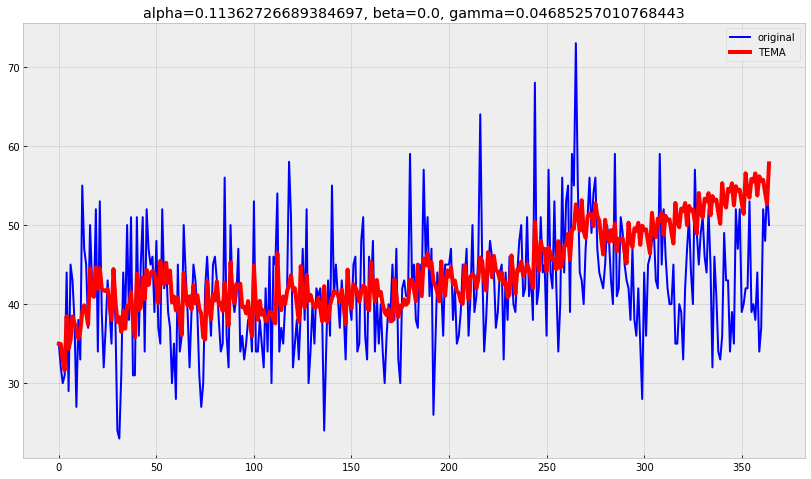

In [325]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))